In [1]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/BSNIP'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['Age_cal'].keys()))
print(len(subs))

1244


In [2]:
import numpy as np

task = 'unk'
x = []
y = []

for sub in subs:
    if demo['DXGROUP_1'][sub] not in ['SZP', 'NC']:
        continue
    p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
    x.append(p)
    y.append(demo['DXGROUP_1'][sub] == 'SZP')
#     y.append(int(demo['Age_cal'][sub]))
#     y.append(demo['sex'][sub] == 'M')
    
x = np.stack(x)
y = np.array(y).astype('int')

print(x.shape)
print(y.shape)
print(y[0:5])

(441, 34716)
(441,)
[1 1 0 1 1]


In [13]:
from sklearn.model_selection import train_test_split

import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F

class Basis(nn.Module):
    def __init__(self, dim):
        super(Basis, self).__init__()
        self.A = nn.Parameter(torch.randn(dim,264,2).float().cuda())
        
    def compute(self, dim=0):
        A = self.A[dim]
        A = A@A.T
        A = A/torch.linalg.norm(A)
        a,b = torch.triu_indices(264,264,offset=1)
        return A[a,b]
    
    def to_img(self, dim=0):
        A = self.A[dim]
        A = A@A.T
        A = A/torch.linalg.norm(A)
        return A.detach().cpu().numpy()
    
    def scramble(self, dim):
        with torch.no_grad():
            self.A[dim] *= 0
            self.A[dim] += torch.randn(264,2).float().cuda()
    
# xtr, xt, ytr, yt = train_test_split(x, y, stratify=y, train_size=0.8)

# xtr = torch.from_numpy(xtr).float().cuda()
# xt = torch.from_numpy(xt).float().cuda()
# ytr = torch.from_numpy(ytr).float().cuda()
# yt = torch.from_numpy(yt).float().cuda()

xtr = torch.from_numpy(x).float().cuda()

# mu = torch.mean(ytr)
# ytr = ytr-mu
# yt = yt-mu
    
w = nn.Parameter(torch.randn(1,xtr.shape[0]).float().cuda())
u = nn.Parameter(torch.randn(1).float().cuda())
    
basis = Basis(3)
optim = torch.optim.Adam(basis.parameters(), lr=1e-1, weight_decay=0)

nepochs = 200
pperiod = 10
eye = torch.eye(1).float().cuda()

def rmse(a,b):
    return torch.mean((a-b)**2)**0.5

for n in range(basis.A.shape[0]):
    tgt = xtr
    cur = None
    print(f'Cur residual')
    with torch.no_grad():
        for m in range(n):
            A = basis.compute(m)
            A = A.unsqueeze(1).detach()
            w,_,_,_ = torch.linalg.lstsq(A.T@A+1e-3*eye, A.T@tgt.T)
            xhat = (A@w).T
            tgt = tgt - xhat
            cur = cur + xhat if cur is not None else xhat
            print(float(rmse(cur, xtr)))
        print(f'Fitting {n}')
    if n > 0:
        start_loss = float(rmse(cur, xtr))
    for epoch in range(nepochs):
        optim.zero_grad()
        A = basis.compute(n)
        A = A.unsqueeze(1)
        w,_,_,_ = torch.linalg.lstsq(A.T@A+1e-3*eye, A.T@tgt.T)
        xhat = (A@w).T
        rloss = rmse(tgt, xhat)
        rloss.backward()
        optim.step()
        if epoch == 0 and n == 0:
            start_loss = float(rloss)
        if epoch % 50 == 49 and float(rloss)/start_loss > 0.9995:
            print('Scrambling')
            basis.scramble(n)
        if epoch % pperiod == 0 or epoch == nepochs:
            print(f'{epoch} {float(rloss)}')
        
print('Complete')

Cur residual
Fitting 0
0 0.3108762204647064
10 0.31086215376853943
20 0.3108574151992798
30 0.31085434556007385
40 0.3108521103858948
Scrambling
50 0.31086936593055725
60 0.2528192698955536
70 0.20676949620246887
80 0.20341132581233978
90 0.20242518186569214
100 0.2016226053237915
110 0.20021332800388336
120 0.19812558591365814
130 0.19700495898723602
140 0.19642654061317444
150 0.19620269536972046
160 0.1961068958044052
170 0.19606918096542358
180 0.19605092704296112
190 0.1960429698228836
Cur residual
0.1960393190383911
Fitting 1
0 0.19603648781776428
10 0.19306787848472595
20 0.19200721383094788
30 0.19185064733028412
40 0.19180916249752045
50 0.19178923964500427
60 0.191775843501091
70 0.191758394241333
80 0.19171272218227386
90 0.1915491223335266
100 0.19101643562316895
110 0.19054341316223145
120 0.19046349823474884
130 0.19039785861968994
140 0.19033168256282806
150 0.19024598598480225
160 0.1901407092809677
170 0.19003449380397797
180 0.18995194137096405
190 0.1899031549692154


In [11]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45, 
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85, 
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132, 
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186, 
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257, 
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,  
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248, 
249, 252, 253]

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

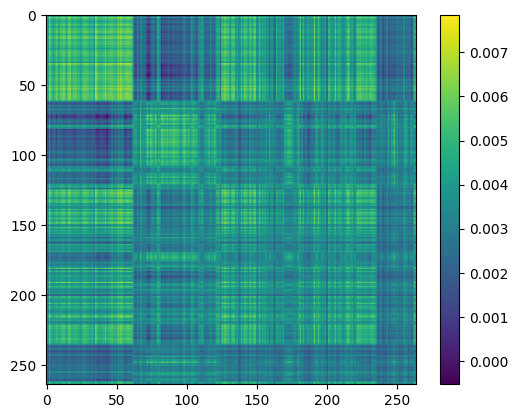

In [12]:
import matplotlib.pyplot as plt

def vec2mat(p):
    if isinstance(p, torch.Tensor):
        p = p.detach().cpu().numpy()
    m = np.zeros((264,264))
    a,b = np.triu_indices(264,1)
    m[a,b] = p
    return m+m.T

plt.imshow(remap(basis.to_img(0)))
# plt.imshow(vec2mat(tgt[0]))
plt.colorbar()
plt.show()

In [393]:
from sklearn.linear_model import LogisticRegression

ws = []
# ytr = ytr.detach().cpu().numpy()
# yt = yt.detach().cpu().numpy()

with torch.no_grad():
    tgt = xtr
    cur = None
    for m in range(basis.A.shape[0]):
        A = basis.compute(m)
        A = A.unsqueeze(1).detach()
        w,_,_,_ = torch.linalg.lstsq(A.T@A+1e-2*eye, A.T@tgt.T)
        ws.append(w)
        xhat = (A@w).T
        tgt = tgt - xhat
        cur = cur + xhat if cur is not None else xhat
        print(float(rmse(cur, xtr)))

print('Done')

ws = torch.cat(ws).T
# ws_np = ws.detach().cpu().numpy()
# clf = LogisticRegression(max_iter=1000).fit(ws_np, ytr)
# yhat = clf.predict(ws_np)
# print(np.mean((yhat == ytr).astype('int')))
u,_,_,_ = torch.linalg.lstsq(ws.T@ws+0*torch.eye(ws.shape[1]).float().cuda(), ws.T@ytr)
yhat = ws@u
print(rmse(yhat,ytr))

ws = []

with torch.no_grad():
    tgt = xt
    cur = None
    for m in range(basis.A.shape[0]):
        A = basis.compute(m)
        A = A.unsqueeze(1).detach()
        w,_,_,_ = torch.linalg.lstsq(A.T@A+1e-2*eye, A.T@tgt.T)
        ws.append(w)
        xhat = (A@w).T
        tgt = tgt - xhat
        cur = cur + xhat if cur is not None else xhat
        print(float(rmse(cur, xt)))
        
ws = torch.cat(ws).T
# ws_np = ws.detach().cpu().numpy()
# yhat = clf.predict(ws_np)
# print(np.mean((yhat == yt).astype('int')))
yhat = ws@u
print(rmse(yhat,yt))
print(rmse(ytr,torch.mean(ytr)))
print(rmse(yt,torch.mean(ytr)))

0.18814559280872345
0.18662159144878387
0.18215811252593994
0.1801310032606125
0.1776232272386551
0.17626337707042694
0.17506782710552216
0.17409224808216095
0.17332151532173157
0.17249858379364014
Done
tensor(13.0233, device='cuda:0')
0.18794532120227814
0.18658214807510376
0.18146328628063202
0.17952193319797516
0.17742855846881866
0.17608362436294556
0.17482425272464752
0.17396634817123413
0.17318648099899292
0.17233389616012573
tensor(13.2303, device='cuda:0')
tensor(13.9770, device='cuda:0')
tensor(14.0681, device='cuda:0')


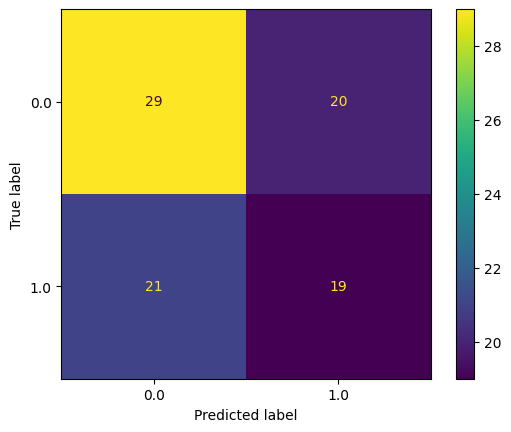

In [174]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(yt, yhat)
plt.show()

In [340]:
import pickle
from natsort import natsorted

basedir = '../../ImageNomer/data/anton/cohorts/test'
demoname = f'{basedir}/demographics.pkl'

with open(demoname, 'rb') as f:
    demo = pickle.load(f)
    
subs = natsorted(list(demo['age'].keys()))
print(len(subs))

830


In [341]:
import numpy as np

task = 'rest'
ox = []

for sub in subs:
    p = np.load(f'{basedir}/fc/{sub}_task-{task}_fc.npy')
    ox.append(p)
    
ox = np.stack(ox)

print(ox.shape)

(830, 34716)


In [18]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

def rmse_np(a, b):
    return np.mean((a-b)**2)**0.5

xtr, xt, ytr, yt = train_test_split(x, y, train_size=0.8)

mu = np.mean(ytr)
ytr = ytr - mu
yt = yt - mu

pca = PCA(n_components=995).fit(xtr)
xxtr = pca.transform(xtr)
xxt = pca.transform(xt)

reg = LinearRegression().fit(xxtr, ytr)
yhat = reg.predict(xxtr)
print(rmse_np(yhat, ytr))
yhat = reg.predict(xxt)
print(rmse_np(yhat, yt))

# clf = LogisticRegression(max_iter=1000).fit(xxtr, ytr)
# yhat = clf.predict(xxtr)
# print(np.mean((yhat == ytr).astype('int')))

# yhat = clf.predict(xxt)
# print(np.mean((yhat == yt).astype('int')))

6.650778078387679e-14
10.42572873339927


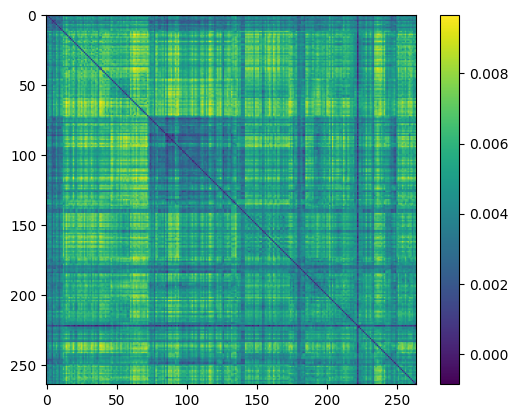

In [27]:
import matplotlib.pyplot as plt

plt.imshow(vec2mat(pca.components_[0]))
plt.colorbar()
plt.show()